In [1]:

#!pip install numpy==1.23.4
#!pip install git+https://github.com/lnccbrown/hssm@main
#!pip install git+https://github.com/brown-ccv/hddm-wfpt@main
#!pip install numpyro


In [2]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Adjust display options
#pd.set_option('display.max_rows', 600)  # Display all rows
#pd.set_option('display.max_columns', None)  # Display all columns
#pd.set_option('display.width', None)  # Allow unlimited width for display

# Initialize empty list 
dfs = []
participant_ids = []

# Iterate through each CSV file in the folder
pathlist = Path("data/").rglob('*.csv')
for participant_id, path in enumerate(pathlist, start=1):
    df = pd.read_csv(path)
    dfs.append(df)
    participant_ids.extend([participant_id] * len(df))

# Concatenate all DataFrames in the list into one DataFrame
combined_df = pd.concat(dfs, ignore_index=True)
combined_df['participant_id'] = participant_ids
#print(combined_df)

# Reorder columns to place participant ID column first
cols = combined_df.columns.tolist()
cols = ['participant_id'] + [col for col in cols if col != 'participant_id']
combined_df = combined_df[cols]

# Clean data
combined_df = combined_df.dropna()
combined_df = combined_df[combined_df.rt != -1]

true_false_lst_mov = []
true_false_lst_or = []

# Iterate through each task type
for task_type in combined_df['task_type'].unique():
    # Filter the DataFrame for the current task type
    task_data = combined_df[combined_df['task_type'] == task_type]
    
    # Iterate through each participant
    for i in range(1, max(task_data['participant_id']) + 1):
        # Filter the DataFrame for the current participant and task type
        participant_data = task_data[(task_data['participant_id'] == i)]
        
        # Count the True and False answers for the current participant
        true_count = participant_data['correct'].eq(True).sum()
        false_count = participant_data['correct'].eq(False).sum()
        total_count = true_count + false_count
        
        # Calculate ratio
        if total_count > 0:
            ratio_count = true_count / total_count
        else:
            ratio_count = 0.0
        
        # Create a dictionary with the counts for the current participant and task type
        bool_dict = {
            "Participant": i,
            "Task_Type": task_type,
            "True": true_count,
            "False": false_count,
            "ratio": ratio_count
        }
        
        # Append the dictionary to respective list based on task type
        if task_type == 'mov':
            true_false_lst_mov.append(bool_dict)
        elif task_type == 'or':
            true_false_lst_or.append(bool_dict)


# Get the intersection of the two lists to find participants meeting both conditions
selected_ids_mov = [x['Participant'] for x in true_false_lst_mov if x['ratio'] >= 0.8]
selected_ids_or = [x['Participant'] for x in true_false_lst_or if x['ratio'] >= 0.8]
selected_ids = list(set(selected_ids_mov).intersection(selected_ids_or))

# Filter the combined_df based on the selected_participant_ids
filtered_df = combined_df[combined_df.participant_id.isin(selected_ids)]


# extra df for plots
df_repetition = filtered_df[filtered_df['task_transition'] == 'repetition']
df_switch = filtered_df[filtered_df['task_transition'] == 'switch']
df_or = filtered_df[filtered_df.task_type != "or"]
df_mov = filtered_df[filtered_df.task_type != "mov"]

# miliseconds to seconds
filtered_df = filtered_df.astype({'rt': 'float64'})
filtered_df.loc[:, 'rt'] = filtered_df['rt'] / 1000
filtered_df.loc[:, 'rt'] = filtered_df[filtered_df['rt'] <= 2]
#change parameter Into numeric
filtered_df['key_press'] = filtered_df['key_press'].map({'f': -1.0, 'j': 1.0})
filtered_df['correct'] = filtered_df['correct'].map({False: 0.0, True: 1.0})
filtered_df['task_type'] = filtered_df['task_type'].map({"or": 0.0, "mov": 1.0})
filtered_df['task_transition'] = filtered_df['task_transition'].map({"repetition": 0.0, "switch": 1.0})
filtered_df['congruency'] = filtered_df['congruency'].map({"congruent": 0.0, "incongruent": 1.0})
filtered_df = filtered_df.rename(columns={"key_press": "response"})
filtered_df = filtered_df.dropna()

filtered_df.drop(['participant_id', 'correct', 'coherent_movement_direction','coherent_orientation','task_type','congruency'], axis='columns', inplace=True)
df = filtered_df
df



#combined_df
#for entry in true_false_lst_or:
#    print(entry)
#for entry in true_false_lst_mov:
#    print(entry)
#for entry in true_false_lst_or:
#    print(entry)
#selected_ids
#len(selected_ids)


,rt,response,task_transition
1,1.164,-1.0,0.0
2,1.502,1.0,0.0
3,1.155,1.0,1.0
4,0.727,1.0,0.0
5,0.677,1.0,0.0
...,...,...,...
3163,1.234,1.0,0.0
3164,0.682,1.0,1.0
3165,1.667,-1.0,0.0
3166,1.481,-1.0,1.0


In [3]:
from matplotlib import pyplot as plt
import arviz as az
import hssm
import hssm.plotting
hssm.set_floatX("float32")

def run_ddm(drift_rate = 1,
            threshold = 1,
            starting_point = 0.5,
            noise_std = 1,
            non_decision_time = 0,
            dt = 0.01,
            max_time = 200):
    """
    Simulates the Drift Diffusion Model for one run with fixed time increments to match evidence points.

    Parameters are the same as the previous function.

    Arguments:
    - drift_rate: rate of evidence accumulation
    - threshold: evidence needed to reach a decision
    - starting_point: initial condition of the evidence
    - noise_std: standard deviation of the noise term
    - non_decision_time: time not included in the evidence accumulation process
    - dt: time increment
    - max_time: maximum simulation time

    Returns:
    - decision_time: the time taken to reach a decision
    - evidence_over_time: the evidence accumulated over time
    - decision: 1 if the decision boundary reached is the upper threshold, -1 if lower
    """
    # Initialize evidence accumulation process
    time = non_decision_time
    evidence = starting_point
    evidence_over_time = [evidence]

    # Run the simulation until a decision boundary is reached or max time is exceeded
    while time < max_time:
        # Increment the evidence by the drift and some noise
        evidence += drift_rate * dt + np.sqrt(dt) * noise_std * np.random.normal()
        evidence_over_time.append(evidence)
        time += dt  # Increment the time

        # Check if the evidence has reached either threshold
        if evidence >= threshold:
            return time, evidence_over_time, 1  # Decision made for the upper threshold
        elif evidence <= 0:
            return time, evidence_over_time, -1  # Decision made for the lower threshold

    # If no decision has been made by max_time, return the current state
    return time, evidence_over_time, 0

def run_ornstein_uhlenbeck(drift_rate=1,
                           threshold=1,
                           starting_point=0.5,
                           noise_std=1,
                           non_decision_time=0,
                           dt=0.01,
                           max_time=200,
                           mean_reversion=1):
    """
    Simulates the Ornstein-Uhlenbeck process for sequential sampling.

    Parameters:
    - drift_rate: rate of evidence accumulation
    - threshold: evidence needed to reach a decision
    - starting_point: initial condition of the evidence
    - noise_std: standard deviation of the noise term
    - non_decision_time: time not included in the evidence accumulation process
    - dt: time increment
    - max_time: maximum simulation time
    - mean_reversion: rate of mean reversion (tendency to return to starting_point)

    Returns:
    - decision_time: the time taken to reach a decision
    - evidence_over_time: the evidence accumulated over time
    - decision: 1 if the upper threshold is reached, -1 if lower
    """
    time = non_decision_time
    evidence = starting_point
    evidence_over_time = [evidence]

    while time < max_time:
        # Drift component
        drift = drift_rate * (threshold - evidence)

        # Diffusion component
        diffusion = np.sqrt(dt) * noise_std * np.random.normal()

        # Mean reversion component
        reversion = mean_reversion * (starting_point - evidence)

        # Update evidence
        evidence += drift * dt + diffusion + reversion * dt
        evidence_over_time.append(evidence)
        time += dt

        # Check decision boundaries
        if evidence >= threshold:
            return time, evidence_over_time, 1  # Upper threshold reached
        elif evidence <= 0:
            return time, evidence_over_time, -1  # Lower threshold reached

    return time, evidence_over_time, 0  # No decision by max_time

def plot_ddm_histograms(rt_upper_simulated, rt_lower_simulated, rt_upper_empirical = None, rt_lower_empirical = None, y_max = 0.5, model_name = ""):

  # Calculate the weights for each group to normalize the histograms
  weights_upper_simulated = np.ones_like(rt_upper_simulated) / float(len(rt_upper_simulated)+len(rt_lower_simulated))
  weights_lower_simulated = np.ones_like(rt_lower_simulated) / float(len(rt_upper_simulated)+len(rt_lower_simulated))

  if rt_upper_empirical is not None and rt_lower_empirical is not None:
    weights_upper_empirical = np.ones_like(rt_upper_empirical) / float(len(rt_upper_empirical)+len(rt_lower_empirical))
    weights_lower_empirical = np.ones_like(rt_lower_empirical) / float(len(rt_upper_empirical)+len(rt_lower_empirical))

  # set up figure
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
  fig.suptitle(model_name)
  # Plot the histograms for upper threshold
  axs[0].hist(rt_upper_simulated, bins=30, weights=weights_upper_simulated, alpha=0.5, color='blue', label='Simulated DDM')
  if rt_upper_empirical is not None:
    axs[0].hist(rt_upper_empirical, bins=30, weights=weights_upper_empirical, alpha=0.5, color='orange', label='Empirical Data')
  axs[0].set_xlabel('Reaction Time (s)')
  axs[0].set_ylabel('Normalized Frequency')
  axs[0].legend()
  axs[1].set_ylim([0, y_max])
  axs[0].set_title('Upper Threshold')

  # Plot the histograms for lower threshold
  axs[1].hist(rt_lower_simulated, bins=30, weights=weights_lower_simulated, alpha=0.5, color='blue', label='Simulated DDM')
  if rt_upper_empirical is not None:
    axs[1].hist(rt_lower_empirical, bins=30, weights=weights_lower_empirical, alpha=0.5, color='orange', label='Empirical Data')
  axs[1].set_xlabel('Reaction Time (s)')
  axs[1].set_ylabel('Normalized Frequency')
  axs[1].legend()
  axs[0].set_ylim([0, y_max])
  axs[1].set_title('Lower Threshold')

  # Adjust layout
  plt.tight_layout()

  # Display the figure
  plt.show()


Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


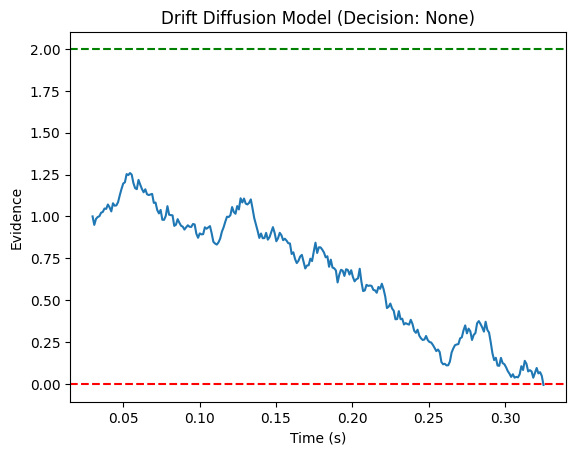

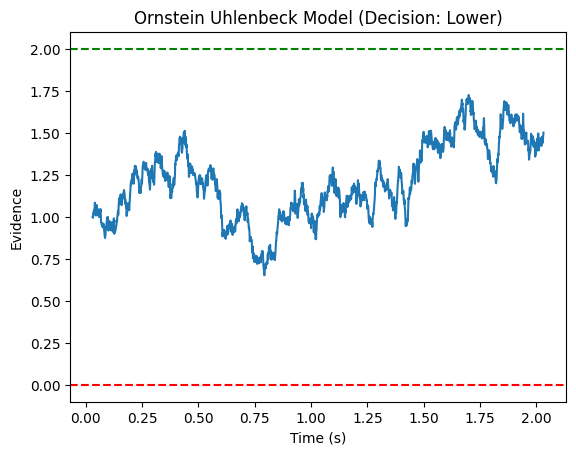

In [4]:
v = 0.01          # drift rate
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
sigma = 1         # standard deviation of noise
t0 = 0.03            # non-decision time
dt = 0.001         # integration constant
max_time = 2   # maximum number of simulated seconds

# Run the simulation with the fixed function
decision_time, evidence_over_time, decision = run_ddm(drift_rate = v,
                                                      threshold = a,
                                                      starting_point = z,
                                                      noise_std = sigma,
                                                      non_decision_time = t0,
                                                      dt = dt,
                                                      max_time = max_time)

# Plot the results with the correct matching of time and evidence points
plt.plot(np.linspace(t0+0, t0+decision_time, len(evidence_over_time)), evidence_over_time)
plt.axhline(y=a, color='green', linestyle='--')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Evidence')
plt.title(f'Drift Diffusion Model (Decision: {"Upper" if decision == 1 else "Lower" if decision == 0 else "None"})')
plt.show()

v = 1             # drift rate
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
sigma = 0.7       # standard deviation of noise
t0 = 0.03         # non-decision time
dt = 0.001        # integration constant
max_time = 2      # maximum number of simulated seconds
mean_reversion=1  # rate of mean reversion (tendency to return to starting_point)

# Run the simulation with the fixed function
decision_time, evidence_over_time, decision = run_ornstein_uhlenbeck(drift_rate = v,
                                                      threshold = a,
                                                      starting_point = z,
                                                      noise_std = sigma,
                                                      non_decision_time = t0,
                                                      dt = dt,
                                                      max_time = max_time)

# Plot the results with the correct matching of time and evidence points
plt.plot(np.linspace(t0+0, t0+decision_time, len(evidence_over_time)), evidence_over_time)
plt.axhline(y=a, color='green', linestyle='--')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Evidence')
plt.title(f'Ornstein Uhlenbeck Model (Decision: {"Upper" if decision == 1 else "Lower" if decision == 0 else "None"})')
plt.show()

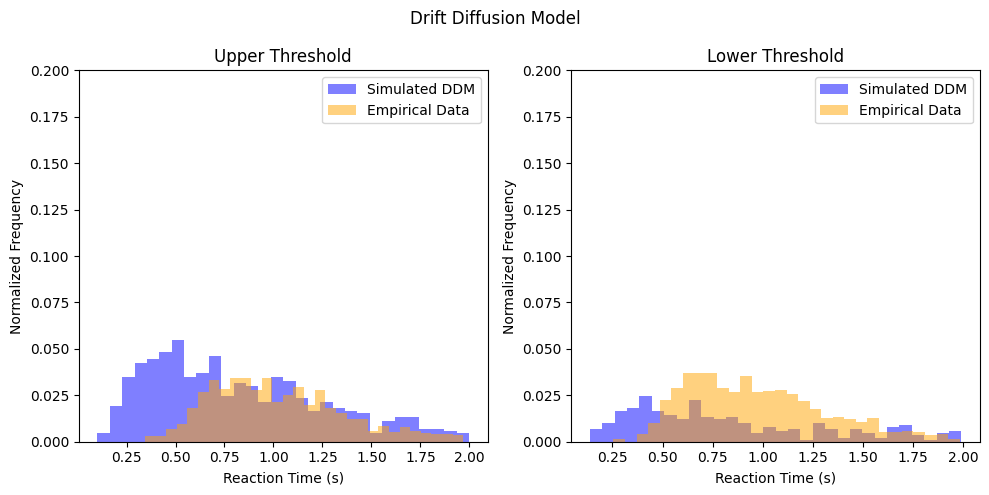

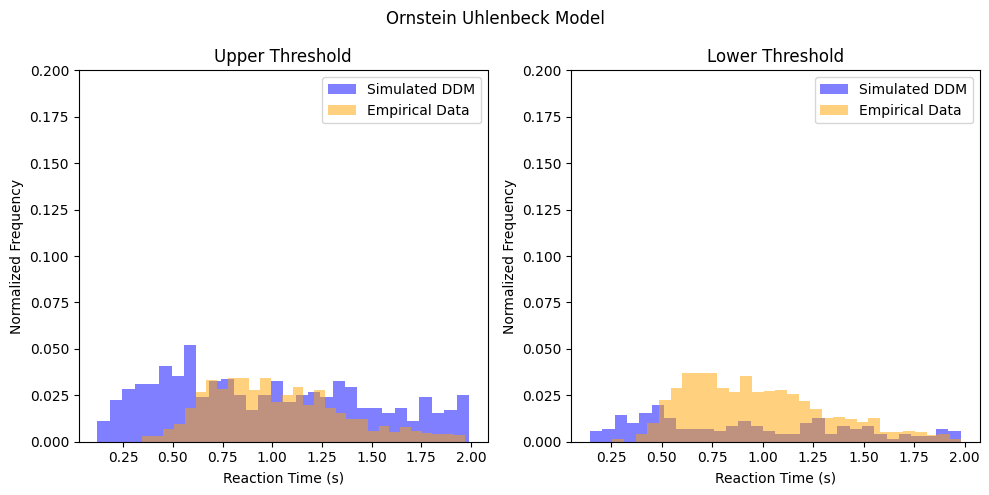

In [5]:
#####################
#### Collected Data
#####################

# Plotting parameters
y_max = 0.2       # maximum of y-axsis

# simulation
empirical_rt_upper = []           # list used to store reaction times for upper boundary
empirical_rt_lower = []           # list used to store reaction times for lower boundary

# simulate the DDM a number of times
for index, row in df.iterrows():

    # if the simulation hit the lower bound, add decision time to list of lower reaction times
    if row['task_transition'] == 0: #orientation
        empirical_rt_lower.append(row['rt'])
    # if the simulation hit the upper bound, add decision time to list of lower upper times
    elif row['task_transition'] == 1: #movement
        empirical_rt_upper.append(row['rt'])


#####################
#### DDM Model
#####################

# DDM parameters
v = 0.5           # drift rate
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
sigma = 1         # standard deviation of noise
t0 = 0.03         # non-decision time
dt = 0.001        # integration constant
max_time = 2      # maximum number of simulated seconds

# Plotting parameters
y_max = 0.2       # maximum of y-axsis

# simulation
num_simulations = 1000  # number of simulated reaction times
rt_upper = []           # list used to store reaction times for upper boundary
rt_lower = []           # list used to store reaction times for lower boundary

# simulate the DDM a number of times
for sim in range(num_simulations):

  # for each simulation, retrive the decision, the evidence trace, and decision time
  decision_time, evidence_over_time, decision = run_ddm(drift_rate = v,
                                                        threshold = a,
                                                        starting_point = z,
                                                        noise_std = sigma,
                                                        non_decision_time = t0,
                                                        dt = dt,
                                                        max_time = max_time)

  # if the simulation hit the lower bound, add decision time to list of lower reaction times
  if decision == -1:
      rt_lower.append(decision_time)
  # if the simulation hit the upper bound, add decision time to list of lower upper times
  elif decision == 1:
      rt_upper.append(decision_time)

plot_ddm_histograms(rt_upper, rt_lower, rt_upper_empirical = empirical_rt_upper, rt_lower_empirical = empirical_rt_lower, y_max = y_max, model_name = 'Drift Diffusion Model')

#####################
#### Ohrnstein Uhlenbeck Model
#####################

# Ohrnstein Uhlenbeck parameters
v = 0.5           # drift rate
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
sigma = 1         # standard deviation of noise
t0 = 0.03         # non-decision time
dt = 0.001        # integration constant
max_time = 2      # maximum number of simulated seconds
mean_reversion=1  # rate of mean reversion (tendency to return to starting_point)

# Plotting parameters
y_max = 0.2       # maximum of y-axsis

# simulation
num_simulations = 1000  # number of simulated reaction times
rt_upper = []           # list used to store reaction times for upper boundary
rt_lower = []           # list used to store reaction times for lower boundary

# simulate the DDM a number of times
for sim in range(num_simulations):

  # for each simulation, retrive the decision, the evidence trace, and decision time
  decision_time, evidence_over_time, decision = run_ornstein_uhlenbeck(drift_rate = v,
                                                        threshold = a,
                                                        starting_point = z,
                                                        noise_std = sigma,
                                                        non_decision_time = t0,
                                                        dt = dt,
                                                        max_time = max_time)

  # if the simulation hit the lower bound, add decision time to list of lower reaction times
  if decision == -1:
      rt_lower.append(decision_time)
  # if the simulation hit the upper bound, add decision time to list of lower upper times
  elif decision == 1:
      rt_upper.append(decision_time)

plot_ddm_histograms(rt_upper, rt_lower, rt_upper_empirical = empirical_rt_upper, rt_lower_empirical = empirical_rt_lower, y_max = y_max, model_name = 'Ornstein Uhlenbeck Model')


In [13]:
import hssm
import jax

varying_drift_model = hssm.HSSM(
    data=df,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + task_transition",
        }
    ],
)

name = "a"
formula = "a ~ 1 + task_transition"

varying_threshold_model = hssm.HSSM(
    data=df,
    include=[
        {
            "name": name,
            "formula": formula,
        }
    ],
)

In [16]:
varying_drift_model_inference = varying_drift_model.sample(
    #sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

varying_threshold_model_inference = varying_threshold_model.sample(
    #sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

model_comparison = az.compare(
    {
        "varying drift": varying_drift_model.traces,
        "varying threshold": varying_threshold_model.traces,
    }
)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, z, t, v_Intercept, v_task_transition]
